__Автор__: Карпаев Алексей, ассистент кафедры информатики и вычислительной математики

# Численное интегрирование, объектно-ориентированный подход

__Постановка задачи__: реализовать первообразную функции

$$
F(x, a) = \int_{a}^{x} f(t) dt
$$


где функция $f(t)$ - определена и интегрируема на отрезке $[a, x]$. Для вычисления значений интеграла будем пользоваться приближенными квадратурными формулами. Введем сетку:

$$
G_h = \{ x_i: x_i = i h; i = 0,...,N; h = \frac{x-a}{N} \}
$$

Используя значения функции в узлах сетки требуется вычислить приближенное значение определенного интеграла от $f(x)$ на отрезке $[a, x]$ с помощью формулы трапеций. Простая реализация численного интегрирования с использованием процедурного стиля:

In [3]:
def Integrate(a, x, function, step=1e-4):
    gridArray = np.arange(a, x, step)
    
    value = 0.
    for i in range(len(gridArray) - 1):
        tCurrent = gridArray[i]
        tNext = gridArray[i + 1]
        value += 0.5*(function(tCurrent) + function(tNext))
    
    value *= step
    return value

In [4]:
import math as m
import numpy as np

print Integrate(1.2, 8.9, lambda t: m.cos(m.sin(t**2)))
print Integrate(2.4, 9.9, lambda t: m.sin(m.cos(t**2)))
print Integrate(4.8, 10.9, lambda t: 2./(3. + m.cos(m.sin(t**2))))
print Integrate(9.8, 21.9, lambda t: 2./(1. - m.exp(m.sin(t**2))))

5.88054244782
0.074872160824
3.24834490331
-1.78775678361


Минусом данной реализации является немного громоздкая строка вызова функции: приходится каждый раз задавать левую границу интегрироания, число точек сетки и подынтегральную функцию. Удобней, когда правая граница является единственным аргументом функции, а остальные величины играют роль параметров:

$$
\int_{a}^{x} f(t)dt = F(\mathbf{x}; f, a, N) 
$$

Исправим недостаток, задействовав классы. Класс __Integral__ с обязательными __полями__:

* левая граница интегрирования
* число узлов сетки
* множество узлов сетки
* шаг численного интегрирования
* интегрируемая функция

__Методы__ класса:

* задать число узлов сетки
* задать интегрируемую функцию
* вычислить значение интеграла используя метод --call--(x)

In [17]:
class Integral:
    """ Class, performing numerical integration of a given function """
    
    def __init__(self):
        print 'An empty Integral is created.'
        
    def ChooseFunction(self, function):
        self._function = function
    
    def SetLeftBorder(self, leftBorder):
        self._leftBorder = leftBorder
    
    def SetGrid(self, step):
        self._step = step
        
    
          
    def __call__(self, x):
        """ Function, performing the numerical integration via a loop """
        self._gridArray = np.arange(self._leftBorder, x, self._step)
        
        self._gridLength = len(self._gridArray)
        
        f, left, right, h = self._function, self._leftBorder, \
                            x, self._step
        
        
        # вычисление по формуле трапеций
        value = 0.
        for i in range(self._gridLength - 1):
            tCurrent = self._gridArray[i]
            tNext = self._gridArray[i + 1]
            value += 0.5*(f(tCurrent) + f(tNext))
            
        value *= self._step
        return value

Тестирование класса:

In [18]:
import math as m

listOfAntiderivatives = [Integral() for i in range(4)]
listOfFunctions = [lambda t: m.exp(-t**2), lambda t: 2./ (1 + m.sin(m.exp(-t**2))),
                   lambda t: m.sinh(5./(2. + m.cos(t))), lambda t: 1./(1 + t**2)]


for element, function in zip(listOfAntiderivatives, listOfFunctions):
    element.ChooseFunction(function)
    element.SetGrid(1e-3)
    element.SetLeftBorder(0.)


# после задания всех параметров пользуемся как функцией    
x0 = 5.4
print listOfAntiderivatives[i](x0) 

# выводим значения всех функций на экран
for element, i in zip(listOfAntiderivatives, range(len(listOfAntiderivatives))):
    print '#%d: Value at the point = %.2f ' % (i, listOfAntiderivatives[i](x0))

Xer
An empty Integral is created.
Xer
An empty Integral is created.
Xer
An empty Integral is created.
Xer
An empty Integral is created.
Xer
Xer
Xer
Xer
1.38765234611
#0: Value at the point = 0.89 
#1: Value at the point = 9.78 
#2: Value at the point = 108.43 
#3: Value at the point = 1.39 


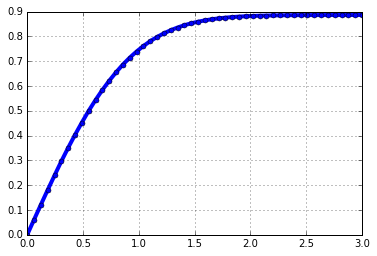

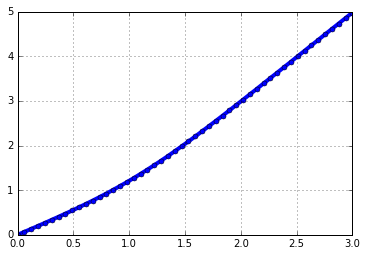

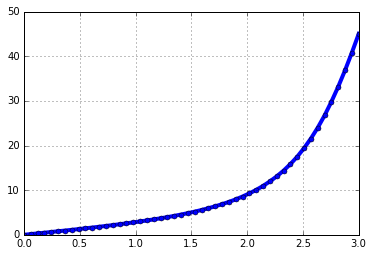

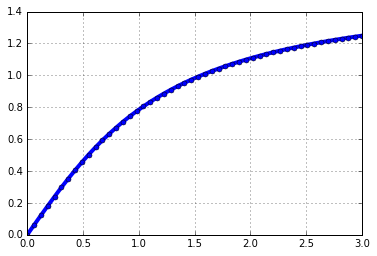

In [10]:
# построение графиков
import matplotlib.pyplot as plt
%matplotlib inline

xData = np.linspace(0., 3.)

for element in listOfAntiderivatives:
    yData = [element(x) for x in list(xData)]
    plt.figure()
    plt.plot(xData, yData, 'b-o', linewidth=4, markersize=5)
    plt.grid('on')
    plt.show()

## Реализация методов численного интегрирования различных порядков точности
Любой метод численного интегрирования можно записать в общем виде:

$$
I_{num} = h \cdot \sum_{i = 0}^{N} c_i f(x_i)
$$

где $\{ c_i \}^{N}_{i=0} - $ список коэффициентов метода, $\{x_i\}^{N}_{i=0}$ - множество точек сетки.


Построить иерархию классов, каждый из которых реализует следующие методы:
* методы левых и правых прямоугольников
* метод средних прямоугольников
* метод трапеций
* метод Симпсона 4-го порядка точности

Все общие поля и методы, которые имеются у каждого класса, отвечающего за свой метод численного интегрирования, поместить в абстрактный класс __AbstractIntegrator__. В классах-наследниках реализовать все то, что свойственно конкретным методам численного интегрирования.

## Вопросы?